## 뉴스 주제 분류 분석

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")
from konlpy.tag import Twitter
import lightgbm as lgb
import requests
import pandas as pd 
from sklearn.metrics import *
import warnings
warnings.filterwarnings('ignore')

In [4]:
def news_data_setting():
    News = pd.read_csv("인공지능 관련 뉴스메타데이터(2013.01.01-2017.08.31).CSV", encoding="cp949")
    News = News.filter(items=["제목","통합 분류1","본문","특성추출"])
    News = News[News['통합 분류1'].notna()]
    News['통합 분류1'] = News['통합 분류1'].replace("경제>국제경제", "경제>경경")
    
    IT = News[News['통합 분류1'].str.contains("IT_과학>")]
    eco = News[News['통합 분류1'].str.contains("경제")]
    spo = News[News['통합 분류1'].str.contains("스포츠>")]
    wol = News[News['통합 분류1'].str.contains("국제")]
    con = News[News['통합 분류1'].str.contains("지역>")]
    so = News[News['통합 분류1'].str.contains("사회")]
    book = News[News['통합 분류1'].str.contains("문화")]
    soc = News[News['통합 분류1'].str.contains("정치")]
    
    IT['class'] = "과학"
    IT['category'] = 1

    eco['class'] = "경제"
    eco['category'] = 2

    spo['class'] = "스포츠"
    spo['category'] = 3

    wol['class'] = "국제"
    wol['category'] = 4

    con['class'] = "지역"
    con['category'] = 5

    so['class'] = "사회"
    so['category'] = 6

    book['class'] = "문화"
    book['category'] = 7

    soc['class'] = "정치"
    soc['category'] = 8
    
    total = pd.concat([IT,eco,spo,wol,con,so,book,soc]).reset_index(drop=True)
    
    return total

total = news_data_setting()

In [5]:
total.tail()

,제목,통합 분류1,본문,특성추출,class,category
45370,일자리·4차 산업혁명·교육…위원회는 `文정부 거울`,정치>청와대,◆ 레이더뉴스 / 文정부 위원회 大해부 ◆ 문재인 대통령이 국정 5개년 계획을 차...,"위원회,청와대,4차,위원장,다음달,일자리,저출산,문재인,북방경제협력위원회,대타협,광...",정치,8
45371,"냉랭한 한일관계, 어떻게 풀어지려나",정치>외교,"우리는 지난 15일 광복 72주년을 보내고, 이제 29일 경술국치일을 맞는다. ...","일본,한일관계,한국,한일,고노,양국간,위안부,문재인,선린,백제,관광객,한국사회,주력...",정치,8
45372,문 대통령 “설계수명 다한 노후원전 연장가동 안한다”,정치>외교,문재인 대통령이 “원전과 화력발전을 줄이고 안전한 미래에너지를 늘려야 한다”고 거듭...,"미국,자유무역협정,중국,기업인,발전소,위원장,사드,경제협력,지방자치단체,신재생,7기...",정치,8
45373,[편집국에서] 사이다만 먹고 살 순 없다,정치>청와대,“공정거래위원회가 (국민들의) 막힌 곳을 뚫어주는 사이다 역할을 하고 있다.” 문재...,"한국,세월호,공정위,기간제,국민들,1류,저성장,가처분,박일근,3류,빅데이터,4차,운...",정치,8
45374,“수직적 권력분산 위해 자치분권 실현 중요”,정치,정순관 대통령소속 지방자치발전위원장은 29일 “자치분권은 시대적 흐름에 부응하는 핵...,"위원장,지방분권,정순관,4차,제2국무회의,지방세,권력분산,수직적,지방이양,인공지능,...",정치,8


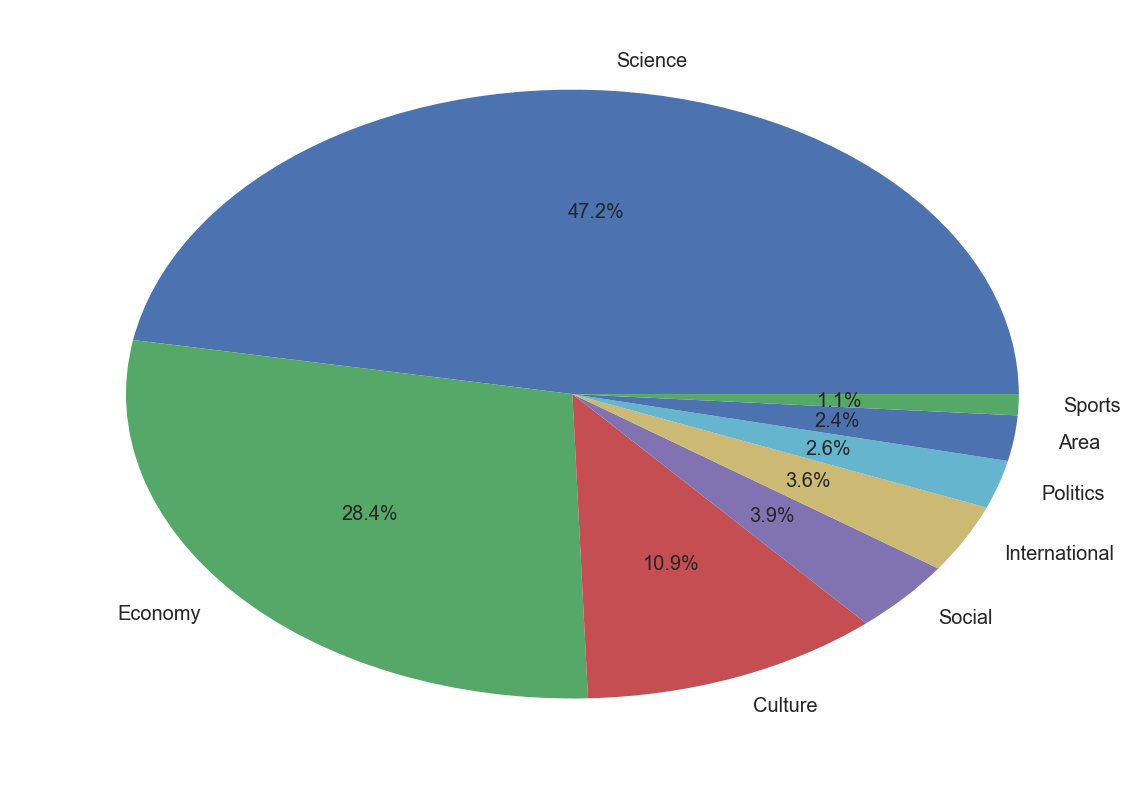

In [123]:
total_v = total['class'].value_counts()
fig = plt.figure(figsize = (10,7))
labels = ['Science','Economy','Culture','Social','International','Politics','Area','Sports',]
plt.pie(total_v, labels=labels ,autopct='%1.1f%%')
plt.show()

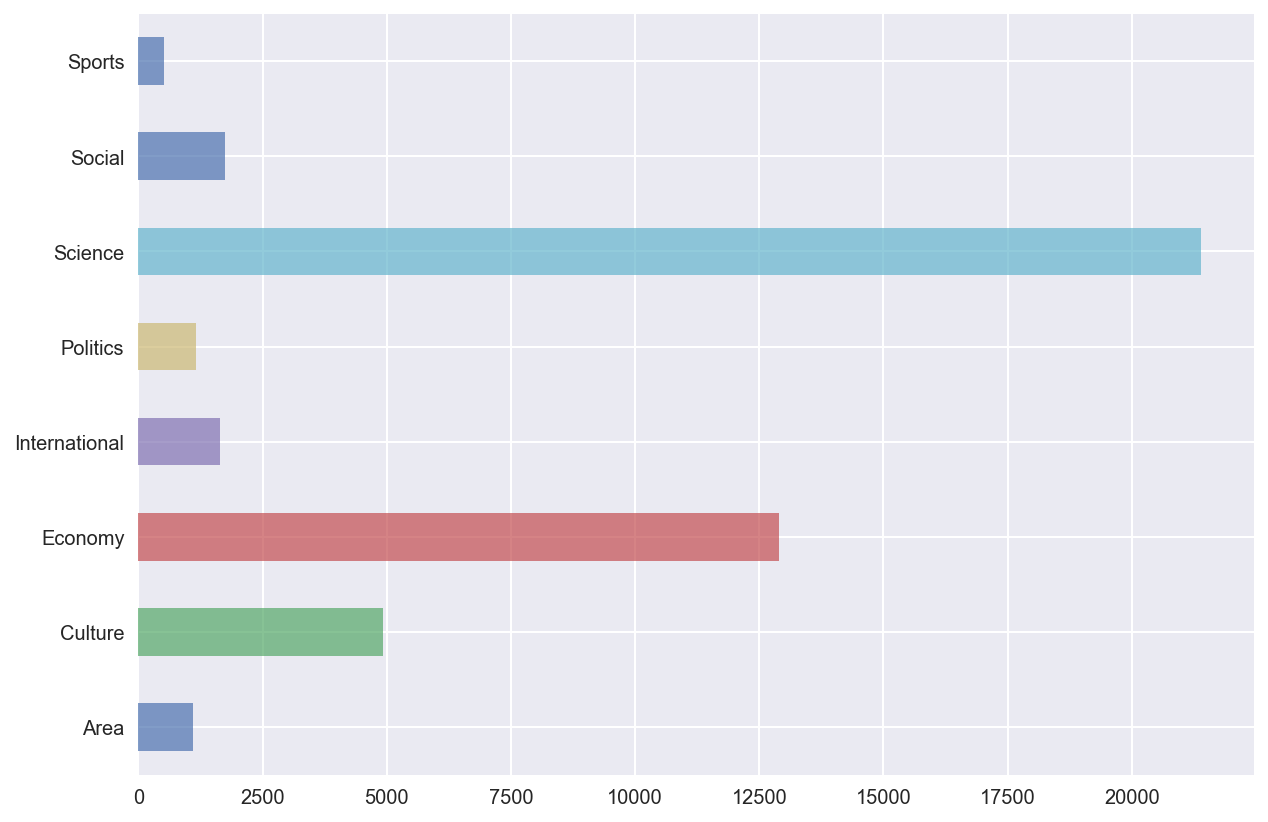

In [132]:
total_v_s = pd.Series({'Science':21397,'Economy':12887,'Culture':4934,'Social':1752,
                       'International':1646,'Politics':1159,'Area':1093,'Sports':507})
fig = plt.figure(figsize = (10,7))
total_v_s.plot(kind="barh", align='center', alpha=0.7)
plt.show()

---

### news 제목

In [35]:
from konlpy.tag import Twitter
from konlpy.tag import *
hannanum = Hannanum()
kkma = Kkma()
twitter = Twitter()

def tokenize_pos(doc):
    return ['/'.join(t) for t in twitter.pos(doc)]

In [36]:
clf = Pipeline([
    ("vect", TfidfVectorizer(tokenizer=tokenize_pos, ngram_range=(1,1))), 
    ("clf", MultinomialNB(alpha=0.01))
])

In [37]:
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(total['제목'], total['category'], \
                                                    test_size=0.4, random_state=0)

len(X_train_a),len(X_test_a),len(y_train_a),len(y_test_a)

(27225, 18150, 27225, 18150)

In [38]:
def news_name():
    model_a = clf.fit(X_train_a, y_train_a)
    
    y_pred_a = model_a.predict(X_train_a)
    
    print("Train", "\n")
    print("Train confusion_matrix", "\n")
    print(confusion_matrix(y_train_a, y_pred_a), "\n\n")
    print("Train classification_report", "\n")
    print(classification_report(y_train_a, y_pred_a), "\n\n")
    print("Train accuracy_score", "\n")
    print(round(accuracy_score(y_train_a, y_pred_a), 2), "\n\n")
    
    print("=====================================================" , "\n\n")
    
    y_pred_a_T = model_a.predict(X_test_a)
    
    print("Test", "\n")
    print("Test confusion_matrix", "\n")
    print(confusion_matrix(y_test_a, y_pred_a_T), "\n\n")
    print("Test classification_report", "\n")
    print(classification_report(y_test_a, y_pred_a_T), "\n\n")
    print("Test accuracy_score", "\n")
    print(round(accuracy_score(y_test_a, y_pred_a_T), 2), "\n\n")
    
    x="Train","Test"
    y=accuracy_score(y_train_a, y_pred_a), accuracy_score(y_test_a, y_pred_a_T)
    plt.bar(x,y)
    plt.show()

Train 

Train confusion_matrix 

[[11991   621    18    53    21    22   190    12]
 [ 1423  6138     2    16    24     5    31    20]
 [   25     1   242     9     0     0    15     0]
 [  171    56     5   713     0     2    19    10]
 [  119    46     1     1   467     3    11     2]
 [  191    29     2     2     6   809    32     9]
 [  386    41    19    12     5    17  2464     2]
 [   57    21     0     3     3     0     1   609]] 


Train classification_report 

             precision    recall  f1-score   support

          1       0.83      0.93      0.88     12928
          2       0.88      0.80      0.84      7659
          3       0.84      0.83      0.83       292
          4       0.88      0.73      0.80       976
          5       0.89      0.72      0.79       650
          6       0.94      0.75      0.83      1080
          7       0.89      0.84      0.86      2946
          8       0.92      0.88      0.90       694

avg / total       0.86      0.86      0.86    

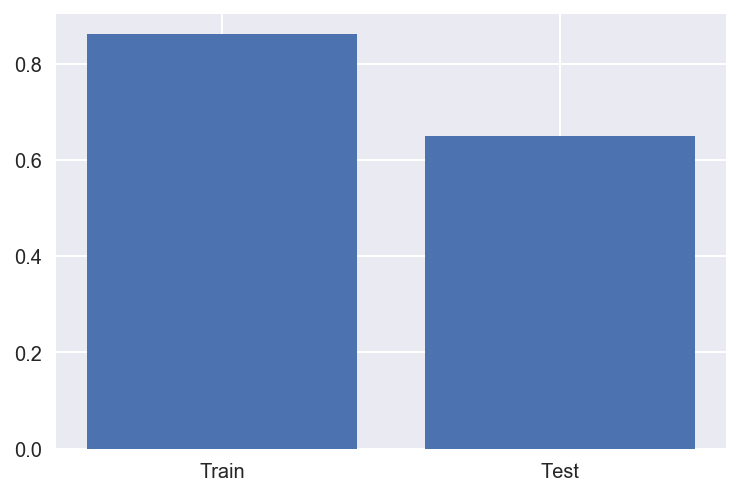

In [39]:
news_name()

---

### news 특성추출

In [40]:
from konlpy.tag import Twitter
from konlpy.tag import *
hannanum = Hannanum()
kkma = Kkma()
twitter = Twitter()

def tokenize_pos(doc):
    return ['/'.join(t) for t in twitter.pos(doc)]

In [41]:
clf = Pipeline([
    ("vect", TfidfVectorizer(tokenizer=tokenize_pos, ngram_range=(1,1))), 
    ("clf", MultinomialNB(alpha=0.01))
])

In [42]:
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(total['특성추출'], total['category'], \
                                                    test_size=0.4, random_state=0)

len(X_train_a),len(X_test_a),len(y_train_a),len(y_test_a)

(27225, 18150, 27225, 18150)

In [283]:
def news_cha():
    model_a = clf.fit(X_train_a, y_train_a)
    
    y_pred_a = model_a.predict(X_train_a)
    
    print("Train", "\n")
    print("Train confusion_matrix", "\n")
    print(confusion_matrix(y_train_a, y_pred_a), "\n\n")
    print("Train classification_report", "\n")
    print(classification_report(y_train_a, y_pred_a), "\n\n")
    print("Train accuracy_score", "\n")
    print(round(accuracy_score(y_train_a, y_pred_a), 2), "\n\n")
    
    print("=====================================================" , "\n\n")
    
    y_pred_a_T = model_a.predict(X_test_a)
    
    print("Test", "\n")
    print("Test confusion_matrix", "\n")
    print(confusion_matrix(y_test_a, y_pred_a_T), "\n\n")
    print("Test classification_report", "\n")
    print(classification_report(y_test_a, y_pred_a_T), "\n\n")
    print("Test accuracy_score", "\n")
    print(round(accuracy_score(y_test_a, y_pred_a_T), 2), "\n\n")
    
    x="Train","Test"
    y=accuracy_score(y_train_a, y_pred_a), accuracy_score(y_test_a, y_pred_a_T)
    plt.bar(x,y)
    plt.show()

Train 

Train confusion_matrix 

[[11925   624    43    65    49    61   149    12]
 [ 1169  6378     6    11    43    14    20    18]
 [    7     1   272     8     1     0     3     0]
 [   97    50    13   799     0     2     7     8]
 [   45    26     2     3   559     4     8     3]
 [   93    29     9     7     6   918    15     3]
 [  239    29    27    18     8    22  2601     2]
 [   28    15     1     1     3     0     2   644]] 


Train classification_report 

             precision    recall  f1-score   support

          1       0.88      0.92      0.90     12928
          2       0.89      0.83      0.86      7659
          3       0.73      0.93      0.82       292
          4       0.88      0.82      0.85       976
          5       0.84      0.86      0.85       650
          6       0.90      0.85      0.87      1080
          7       0.93      0.88      0.90      2946
          8       0.93      0.93      0.93       694

avg / total       0.89      0.89      0.88    

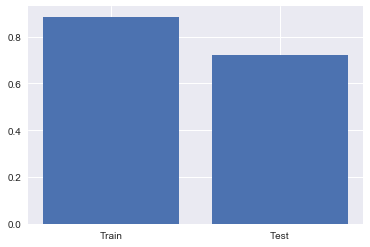

In [284]:
news_cha()

---

### news 본문

In [14]:
from konlpy.tag import Twitter
from konlpy.tag import *
hannanum = Hannanum()
kkma = Kkma()
twitter = Twitter()

def tokenize_pos(doc):
    return ['/'.join(t) for t in twitter.pos(doc)]

In [15]:
clf = Pipeline([
    ("vect", TfidfVectorizer(tokenizer=tokenize_pos, ngram_range=(1,2))), 
    ("clf", MultinomialNB(alpha=0.01))
])

In [16]:
X_train_F, X_test_F, y_train_F, y_test_F = train_test_split(total['본문'], total['category'], \
                                                    test_size=0.1, random_state=0)

len(X_train_F),len(X_test_F),len(y_train_F),len(y_test_F)

(40837, 4538, 40837, 4538)

In [17]:
def news_con():
    model_F = clf.fit(X_train_F, y_train_F)
    
    y_pred_F = model_F.predict(X_train_F)
    
    print("Train", "\n")
    print("Train confusion_matrix", "\n")
    print(confusion_matrix(y_train_F, y_pred_F), "\n\n")
    print("Train classification_report", "\n")
    print(classification_report(y_train_F, y_pred_F), "\n\n")
    print("Train accuracy_score", "\n")
    print(round(accuracy_score(y_train_F, y_pred_F), 2), "\n\n")
    
    print("=====================================================" , "\n\n")
    
    y_pred_F_T = model_F.predict(X_test_F)
    
    print("Test", "\n")
    print("Test confusion_matrix", "\n")
    print(confusion_matrix(y_test_F, y_pred_F_T), "\n\n")
    print("Test classification_report", "\n")
    print(classification_report(y_test_F, y_pred_F_T), "\n\n")
    print("Test accuracy_score", "\n")
    print(round(accuracy_score(y_test_F, y_pred_F_T), 2), "\n\n")
    
    x="Train","Test"
    y=accuracy_score(y_train_F, y_pred_F), accuracy_score(y_test_F, y_pred_F_T)
    plt.bar(x,y)
    plt.show()

Train 

Train confusion_matrix 

[[18613   235    36    77    50    39   169     8]
 [  162 11371     6    12    30    10    32    14]
 [    1     2   454     3     0     0     1     0]
 [    8    11     1  1456     0     2     2     3]
 [    7     4     2     2   943     1     9     1]
 [    3     7     4     2     6  1551     5     2]
 [   33    10     9    10     8     7  4382     2]
 [    3     2     0     0     1     0     0  1013]] 


Train classification_report 

             precision    recall  f1-score   support

          1       0.99      0.97      0.98     19227
          2       0.98      0.98      0.98     11637
          3       0.89      0.98      0.93       461
          4       0.93      0.98      0.96      1483
          5       0.91      0.97      0.94       969
          6       0.96      0.98      0.97      1580
          7       0.95      0.98      0.97      4461
          8       0.97      0.99      0.98      1019

avg / total       0.97      0.97      0.97    

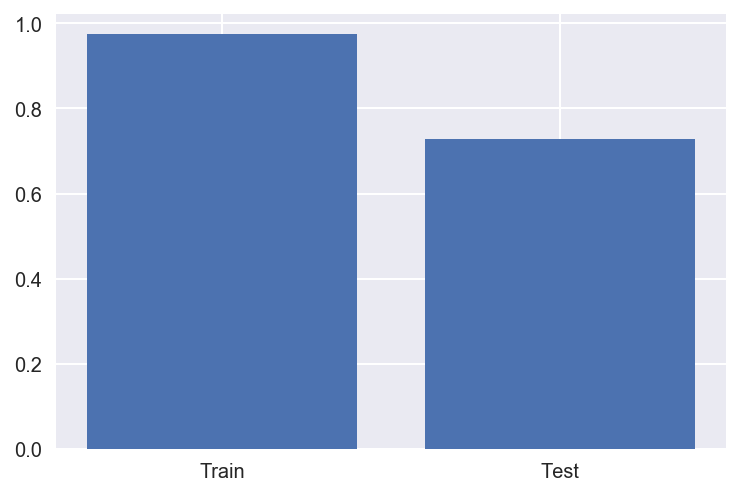

In [18]:
news_con()

---

### news 본문 + 특성추출 + 제목

In [21]:
def data_resetting():
    total_ = total.filter(items=['본문',"class",'category'])
    total_ = total_.rename(columns={"본문":"cont"})
    total__ = total.filter(items=['특성추출',"class",'category'])
    total__ = total__.rename(columns={"특성추출":"cont"})
    total___ = total.filter(items=['제목',"class",'category'])
    total___ = total___.rename(columns={"제목":"cont"})
    
    t_total = pd.concat([total_,total__,total___]).reset_index(drop=True)
    
    return t_total

t_total = data_resetting()

In [22]:
t_total.tail()

,cont,class,category
136120,일자리·4차 산업혁명·교육…위원회는 `文정부 거울`,정치,8
136121,"냉랭한 한일관계, 어떻게 풀어지려나",정치,8
136122,문 대통령 “설계수명 다한 노후원전 연장가동 안한다”,정치,8
136123,[편집국에서] 사이다만 먹고 살 순 없다,정치,8
136124,“수직적 권력분산 위해 자치분권 실현 중요”,정치,8


In [23]:
from konlpy.tag import Twitter
from konlpy.tag import *
hannanum = Hannanum()
kkma = Kkma()
twitter = Twitter()

def tokenize_pos(doc):
    return ['/'.join(t) for t in twitter.pos(doc)]

In [33]:
clf = Pipeline([
    ("vect", TfidfVectorizer(tokenizer=tokenize_pos)), 
    ("clf", MultinomialNB(alpha=0.01))
])

In [34]:
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(t_total['cont'], t_total['category'], \
                                                    test_size=0.1, random_state=0)

len(X_train_a),len(X_test_a),len(y_train_a),len(y_test_a)

(122512, 13613, 122512, 13613)

Train 

Train confusion_matrix 

[[51684  3633   269   298   217   219  1376    98]
 [ 8156 25917    25    64   196    75   214   141]
 [  127    17  1146    35     4     0    44     1]
 [  894   423   105  2813     1    18   150    38]
 [  527   235    17     5  2079    26    68    20]
 [  992   181    39    26    58  3203   198    42]
 [ 2129   205   267    93    88   128 10371    20]
 [  348   169    10    15    17     8    47  2483]] 


Train classification_report 

             precision    recall  f1-score   support

          1       0.80      0.89      0.84     57794
          2       0.84      0.74      0.79     34788
          3       0.61      0.83      0.70      1374
          4       0.84      0.63      0.72      4442
          5       0.78      0.70      0.74      2977
          6       0.87      0.68      0.76      4739
          7       0.83      0.78      0.80     13301
          8       0.87      0.80      0.84      3097

avg / total       0.82      0.81      0.81    

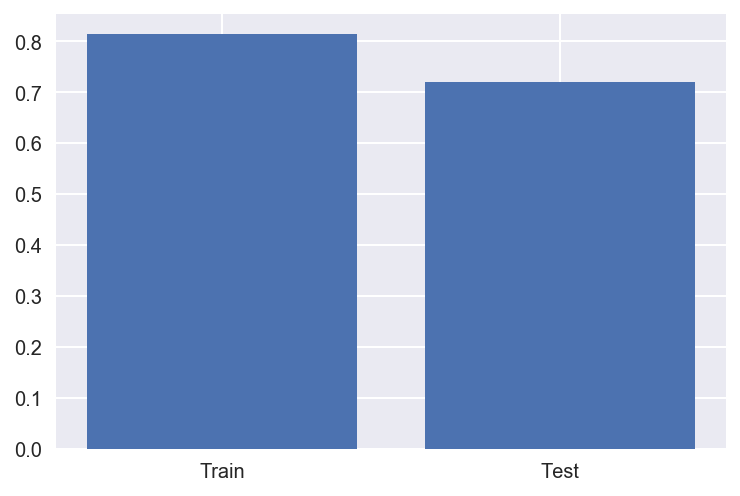

In [35]:
# def total():
model_a = clf.fit(X_train_a, y_train_a)

y_pred_a = model_a.predict(X_train_a)

print("Train", "\n")
print("Train confusion_matrix", "\n")
print(confusion_matrix(y_train_a, y_pred_a), "\n\n")
print("Train classification_report", "\n")
print(classification_report(y_train_a, y_pred_a), "\n\n")
print("Train accuracy_score", "\n")
print(round(accuracy_score(y_train_a, y_pred_a), 2), "\n\n")

print("=====================================================" , "\n\n")

y_pred_a_T = model_a.predict(X_test_a)

print("Test", "\n")
print("Test confusion_matrix", "\n")
print(confusion_matrix(y_test_a, y_pred_a_T), "\n\n")
print("Test classification_report", "\n")
print(classification_report(y_test_a, y_pred_a_T), "\n\n")
print("Test accuracy_score", "\n")
print(round(accuracy_score(y_test_a, y_pred_a_T), 2), "\n\n")

x="Train","Test"
y=accuracy_score(y_train_a, y_pred_a), accuracy_score(y_test_a, y_pred_a_T)
plt.bar(x,y)
plt.show()

### 문구 Test  (과학:1, 경제:2, 스포츠:3, 국제:4, 지역:5, 사회:6, 문학:7, 정치:8)

In [37]:
X_=pd.Series("개헌")

y_pred_t = model_a.predict_proba(X_)
y_pred = model_a.predict(X_)

print(y_pred_t)
print(y_pred)

[[0.00142078 0.00139733 0.00127244 0.06951734 0.06108953 0.01926762
  0.04204247 0.80399249]]
[8]


In [32]:
X_=pd.Series(str(input("insert 1number : ")))

y_pred_t = model_a.predict_proba(X_)
y_pred = model_a.predict(X_)

print(y_pred_t)
print(y_pred)

insert 1number : 부동산
[[0.30173042 0.63621373 0.00165791 0.0095907  0.00423226 0.01091773
  0.02848678 0.00717046]]
[2]


---

### Class 축소 (과학:1, 경제:2, 스포츠:3, 국제:4, 지역:5, 사회:6, 문학:7, 정치:8)

세분화된 분류안에 과학, 경제, 스포츠등이 녹아 들어가 있기 때문에 처리 고민 후 진행 예정


목표는 예측 정확도 높이기 위함

In [36]:
total.tail()

,제목,통합 분류1,본문,특성추출,class,category
45370,일자리·4차 산업혁명·교육…위원회는 `文정부 거울`,정치>청와대,◆ 레이더뉴스 / 文정부 위원회 大해부 ◆ 문재인 대통령이 국정 5개년 계획을 차...,"위원회,청와대,4차,위원장,다음달,일자리,저출산,문재인,북방경제협력위원회,대타협,광...",정치,8
45371,"냉랭한 한일관계, 어떻게 풀어지려나",정치>외교,"우리는 지난 15일 광복 72주년을 보내고, 이제 29일 경술국치일을 맞는다. ...","일본,한일관계,한국,한일,고노,양국간,위안부,문재인,선린,백제,관광객,한국사회,주력...",정치,8
45372,문 대통령 “설계수명 다한 노후원전 연장가동 안한다”,정치>외교,문재인 대통령이 “원전과 화력발전을 줄이고 안전한 미래에너지를 늘려야 한다”고 거듭...,"미국,자유무역협정,중국,기업인,발전소,위원장,사드,경제협력,지방자치단체,신재생,7기...",정치,8
45373,[편집국에서] 사이다만 먹고 살 순 없다,정치>청와대,“공정거래위원회가 (국민들의) 막힌 곳을 뚫어주는 사이다 역할을 하고 있다.” 문재...,"한국,세월호,공정위,기간제,국민들,1류,저성장,가처분,박일근,3류,빅데이터,4차,운...",정치,8
45374,“수직적 권력분산 위해 자치분권 실현 중요”,정치,정순관 대통령소속 지방자치발전위원장은 29일 “자치분권은 시대적 흐름에 부응하는 핵...,"위원장,지방분권,정순관,4차,제2국무회의,지방세,권력분산,수직적,지방이양,인공지능,...",정치,8


In [38]:
News = pd.read_csv("인공지능 관련 뉴스메타데이터(2013.01.01-2017.08.31).CSV", encoding="cp949")

In [41]:
News['통합 분류1'].value_counts().sort_index()

IT_과학>IT_과학일반    1280
IT_과학>과학         8481
IT_과학>모바일        2907
IT_과학>보안          772
IT_과학>인터넷_SNS    7274
IT_과학>콘텐츠         683
경제                546
경제>국제경제           674
경제>금융_재테크        1066
경제>무역              62
경제>반도체            595
경제>부동산            156
경제>산업_기업         6337
경제>서비스_쇼핑         495
경제>외환               3
경제>유통             279
경제>자동차            593
경제>자원             122
경제>증권_증시         1133
경제>취업_창업          826
국제                872
국제>러시아             15
국제>미국_북미           58
국제>아시아             19
국제>유럽_EU          154
국제>일본             192
국제>중국             322
국제>중남미              6
국제>중동_아프리카          8
문화                998
                 ... 
스포츠>야구>메이저리그        1
스포츠>야구>일본프로야구       3
스포츠>야구>한국프로야구       8
스포츠>올림픽_아시안게임      20
스포츠>월드컵            20
스포츠>축구              5
스포츠>축구>한국프로축구       8
스포츠>축구>해외축구         8
정치                182
정치>국회_정당          206
정치>북한              35
정치>선거             145
정치>외교             134
정치>청와대            248
정치>행정_자치  

In [45]:
News[News['통합 분류1'] == "지역>충북"]

,주소,일자,언론사,기고자,제목,통합 분류1,통합 분류2,통합 분류3,사건/사고 분류1,사건/사고 분류2,사건/사고 분류3,개체명(인물),개체명(지역),개체명(기업/기관),키워드,특성추출,본문,원본주소
25,http://www.bigkinds.or.kr/news/newsDetailView....,20130112,서울신문,NaN,헤드램프도 ‘인공지능 시대’,지역>충북,경제>자동차,NaN,NaN,NaN,NaN,NaN,독일충북제천대전서울,현대모비스기아차,"헤드램프,인공,지능,시대,자동차,헤드,램프,인공,지능,시대,밤길,운전,차량,내비게이...","헤드램프,스티어링휠,자동차,사각지대,관계자,교차로,사이드램프,현대모비스,기아차,독일...",자동차 헤드램프도 ‘인공지능 시대’가 열렸다. 밤길 운전에서 미리 갈 곳을 비춰주는...,http://www.seoul.co.kr/news/newsView.php?id=20...
8349,http://www.bigkinds.or.kr/news/newsDetailView....,20160314,충청투데이,이완종 기자,충북에도 ‘바둑 바람’ 분다,지역>충북,NaN,NaN,NaN,NaN,NaN,김경애,충북흥덕구청주시분평동충북도,구글충북도한국,"충북,바둑,바람,분다,세계,대표,한국,프로바둑기사,인공지능,대결,충북,바둑학원,문의...","바둑학원,인공지능,9단,알파고,바둑교실,청주시,학부모,흥덕구,문의전화,충북도,학부모...",세계를 대표하는 한국의 프로바둑기사와 인공지능 간의 대결이 열리고 있는 가운데 충북...,http://www.cctoday.co.kr/?mod=news&act=article...
8683,http://www.bigkinds.or.kr/news/newsDetailView....,20160315,문화일보,정우천,‘세돌키즈’ 키우자… 초·중·고교 바둑부 창단 ‘붐’,지역>충북,지역>전남,스포츠>스포츠일반,NaN,NaN,NaN,이세돌백태금이도현,충북상당고청주순천한국광산구원평중전남광주,남성초첨단중학교순천충북도교육청충북교육청한국기원원평중문화일보,"세돌키즈,고교,바둑부,창단,대국,관심,고조,전용실,지도,코치,집중,충북교육청,육성학...","바둑부,충북,한국기원,9단,3학년,알파고,3개,학부모,원평중,전용실,순천,백태금,광...",‘알파고 대국’으로 관심 고조 전용실 만들고 코치 집중 지도 충북교육청 육성학교...,NaN
9771,http://www.bigkinds.or.kr/news/newsDetailView....,20160318,충청투데이,충청투데이,알파고가 남긴 과제,지역>충북,IT_과학>과학,NaN,NaN,NaN,NaN,데미스허사비스,충북,구글충북청주시설관리공단단양관광관리공단충북도AI충북개발공사미래산업SK하이닉스,"알파고,구글,마인드사,프로그래밍,인공지능,AI,알파고,AlphaGo,이세돌,9단,세...","충북,일자리창출,충북도,9단,ai,알파고,중장기,지방공기업,임금피크제,단체장,일자리...",지난 한 주 구글의 딥 마인드사가 프로그래밍 한 인공지능(AI) 알파고(AlphaG...,http://www.cctoday.co.kr/?mod=news&act=article...
11627,http://www.bigkinds.or.kr/news/newsDetailView....,20160408,세계일보,김을지,"""제2의 이세돌 꿈꾼다"" 청주 원평중 바둑부 창단",지역>충북,NaN,NaN,NaN,NaN,NaN,이세돌,충북청주일,남성초상당고바둑협회충북도교육청원평중충북바둑협회원평중학교,"제2,이세돌,청주,원평중,바둑부,창단,충북,학교,바둑부,8일,충북도교육청,충북바둑협...","바둑부,청주,충북,원평중,9단,이세돌,4명,3학년,3단,창단식,순회코치,바둑협회,알...",충북에도 학교 바둑부가 생긴다. 8일 충북도교육청과 충북바둑협회에 따르면 청주 원...,http://www.segye.com/content/html/2016/04/08/2...
12961,http://www.bigkinds.or.kr/news/newsDetailView....,20160503,충북일보,손근방,충북교육감 영동지역서 교육현장 목소리 소통토론회,지역>충북,NaN,NaN,NaN,NaN,NaN,NaN,상촌초충북영동지역,충북교육감영동영동교육지원청영신중학교,"충북교육감,영동,지역,소통토론회,교육,현장,목소리,소통,토론회,영동교육지원청,대강당...","영동,소통토론회,영동교육지원청,교육감,행복씨앗학교,토론회,교직원,학부모,충북교육감,...",[충북일보=영동] 영동교육지원청은 3일 영신중학교 대강당에서 김병우 충북교육감 등이...,http://www.inews365.com/news/article.html?no=4...
12963,http://www.bigkinds.or.kr/news/newsDetailView....,20160503,충청일보,김국기 기자,영동 교육현장 목소리 청취,지역>충북,사회,NaN,NaN,NaN,NaN,김병우,영동상촌초충북,충북교육감영동영동교육지원청영신중학교,"영동,교육,현장,목소리,청취,김병우,충북교육감,3일,영동,영신중학교,대강당,지역,학...","영동,교육감,행복씨앗학교,대강당,토론회,소통토론회,참석자들,참석자,충북,교직원,학부...",[영동=충청일보 김국기기자] 김병우 충북교육감은 3일 영동 영신중학교 대강당에서 이...,http://www.ccdailynews.com/news/articleView.ht...
12977,http://www.bigkinds.or.kr/news/newsDetailView....,20160504,충북일보,손근방,충북교육감 영동지역서 교육현장 목소리 소통토론회 가져,지역>충북,NaN,NaN,NaN,NaN,NaN,NaN,상촌초충북영동지역,충북교육감영동영동교육지원청영신중학교,"충북교육감,영동,지역,소통토론회,교육,현장,목소리,소통,토론회,충북교육감,영동,지역...","소통토론회,영동,영동교육지원청,토론회,교육감,충북교육감,행복씨앗학교,교직원,학부모,...",충북교육감 영동지역서 교육현장 목소리 소통토론회 가져 영동교육지원청은 3일 영신중...,NaN
14177,http://www.bigkinds.or.kr/news/newsDetailView....,20160526,충북일보,조항원,"진천교육지원청, 교육감과의 톡&톡 소통토론회 개최",지역>충북,NaN,NaN,NaN,NaN,NaN,김병우,진천충북진천지역충북도,광혜원중진천상업고등학교진천교육지원청,"진천교육지원청,교육감,톡&,소통,토론회,개최,김병우,교육감,토론회,학부모들,만남,충...","토론회,교육감,학부모,교육정책,진천,지원청,충북도,소통토론회,김병우,진천지역,진천상...",-김병우 교육감이 토론회에 앞서 학부모들과 만남의 시간을 갖고 있다. [충북일보=진...,http://www.inews365.com/news/article.html?no=4...
14265,http://www.bigkinds.or.kr/news/newsDetailView....,20160527,중부매일,한기현 기자,"진천교육지원청, '교육감과의 톡톡 소통' 토론회",지역>충북,사회>교육_시험,NaN,NaN,NaN,NaN,김병우,충북진천,광혜원중학교진천상업고등학교진천교육지원청,"진천교육지원청,교육감,소통,토론회,중부매일,한기현,진천교육지원청,강당,진천상업고등학...","교육감,토론회,한기현,학부모,충북,교직원,진천상업고등학교,학교운영위원,공동체,중부매...",〔중부매일 한기현 기자〕진천교육지원청은 26일 진천상업고등학교 강당에서 지역 교육현...,http://www.jbnews.com/news/articleView.html?id...


---